<a href="https://colab.research.google.com/github/mkm-world/DSN-AI-Bootcamp-2024-Qualification-Hackathon/blob/main/DSN_Bootcamp_2024_Qualification_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease Prediction - DSN Bootcamp Hackathon

## Introduction
This notebook presents a solution for the DSN Bootcamp Hackathon challenge hosted on Zindi. The goal is to create a sophisticated predictive model to determine the likelihood of an individual having heart disease.

Heart disease is one of the leading causes of global mortality, and early detection is crucial for improving patient outcomes. This challenge aims to develop a cost-effective and efficient method for assessing heart disease risk using readily available patient information.

## Objective
The main objective is to design and build a machine learning model that can accurately predict the probability of an individual having heart disease. The model should demonstrate high accuracy and generalizability to ensure its effectiveness on new, unseen data.

## Significance
Solving this challenge has several important implications:
1. Early prediction enables timely intervention and prevention.
2. Cost-effective predictive models can optimize healthcare resources.
3. Targeted public health efforts can be developed based on aggregated data.
4. Insights from the model can advance research in the field.

This notebook documents my approach to addressing this crucial healthcare issue using advanced machine learning techniques.

## Data Loading and Exploration

In this section, we load the provided datasets and perform initial exploratory data analysis to understand the structure and characteristics of our data.

## Setup and Data Loading





### Environment Information

To ensure reproducibility and provide context for the analysis, here are the versions of the main packages used in this notebook:

- Python: 3.10.12
- pandas: 2.1.4
- numpy: 1.26.4
- matplotlib: 3.7.1
- seaborn: 0.13.1
- scikit-learn: 1.5.2
- xgboost: 2.1.1
- catboost: 1.2.7
- optuna: 4.0.0

### Importing the Required Libraries

In [4]:
import pandas as pd # Importing pandas library and aliasing it as pd
import numpy as np # Importing numpy library and aliasing it as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # Importing pyplot module from matplotlib library and aliasing it as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns # Importing seaborn library and aliasing it as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)   # Setting pandas option to display all columns in DataFrame
plt.style.use('ggplot')  # Setting plot style to 'ggplot' from matplotlib

### Mount Drive

In [5]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# set working directory
%cd /content/drive/MyDrive/DSN Bootcamp 2024 Qualification Hackathon

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DSN Bootcamp 2024 Qualification Hackathon


### Data Import
In this section, we load the provided datasets for our heart disease prediction task.

In [6]:
# read train
train = pd.read_csv("Train Dataset .csv")

train.head()

,Id,Age,Sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,16167,33,0,1,158,205,1,0,154,0,1.5,1,4,1,1
1,11275,53,1,2,198,154,0,1,104,0,0.8,2,1,0,0
2,13251,37,1,2,101,202,1,0,155,0,2.1,1,3,1,1
3,19921,75,0,0,113,306,1,2,88,1,4.9,0,2,2,1
4,11293,35,1,2,139,419,1,1,166,1,0.9,2,4,0,1


In [7]:
test = pd.read_csv("Test Dataset.csv")

test.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,16501,70,1,0,163,495,0,2,170,1,2.0,1,0,1
1,10444,61,1,0,131,238,0,2,74,1,4.9,2,2,2
2,14288,53,1,0,95,558,1,1,73,1,0.7,1,1,0
3,10409,37,0,1,178,287,0,1,192,1,5.7,1,0,0
4,17330,35,0,3,104,281,0,0,122,0,1.3,1,4,3


In [8]:
sample_sub = pd.read_csv("Sample Submission.csv")

sample_sub.head()

,Id
0,16501
1,10444
2,14288
3,10409
4,17330


## Data Preprocessing

Here, we clean the data,clean the column names, handle missing values, and prepare the features for model training. This includes encoding categorical variables and scaling numerical features.

### Checking for consistency in column names

In [9]:
# print list of columns present in train but missing in test
print("Columns present in train but missing in test ",[col for col in train.columns if col not in test.columns])

# print list of columns present in test but missing in train
print("Columns present in test but missing in train ",[col for col in test.columns if col not in train.columns])

Columns present in train but missing in test  ['Id', 'Age', 'Sex', 'target']
Columns present in test but missing in train  ['id', 'age', 'sex']


There is a mismatch in the naming of the "id", "age" and "sex"  columns as some they are represented in different cases in the two datasets. To fix this, all column names will be put in lowercase to ensure consistency and prevent errors further down the processing and prediction pipeline.

### Cleaning Column names

In [10]:
new_train_cols = [col.lower() for col in train.columns]
new_test_cols = [col.lower() for col in test.columns]

train.columns = new_train_cols
test.columns = new_test_cols

### Combining train and test dataframes for easy and consistent preprocessing

In [11]:
# combine train and test dfs for easier and consistent preprocessing
train['source'] = 'train'
test['source'] = 'test'

all_data = pd.concat([train, test], axis = 0)

display(all_data.sample(10))

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,source
3162,12368,47,0,3,165,445,0,2,97,0,2.7,0,0,1,0.0,train
996,15372,31,0,2,104,179,0,1,128,1,2.6,2,4,2,1.0,train
4921,13072,31,0,2,149,183,0,0,77,1,2.6,2,3,1,1.0,train
2313,19263,72,0,3,143,341,0,2,169,1,4.1,1,0,2,NaN,test
961,17893,46,1,1,186,502,1,1,173,0,5.3,0,3,2,1.0,train
634,16039,32,1,2,146,279,1,2,199,1,5.5,0,0,2,NaN,test
6903,10480,50,1,1,105,366,0,1,84,1,5.0,2,1,1,1.0,train
1298,16693,30,0,0,104,488,0,0,120,1,0.8,0,3,1,NaN,test
4788,18104,32,0,2,175,183,1,1,151,0,0.5,2,0,0,0.0,train
2653,14717,54,1,1,97,524,0,0,138,1,3.3,0,3,0,NaN,test


#### CHECKING FOR MISSING VALUES

In [12]:
# Counting missing values in each column
missing_values_count = all_data.isnull().sum()

# Calculating the proportion of missing values for each column
missing_values_proportion= all_data.isnull().sum() / len(all_data)

# Combining count and proportion into one DataFrame for a clean summary
missing_values_summary = pd.DataFrame({
    'Missing Values': missing_values_count,
    'Proportion': missing_values_proportion
})
# Displaying the summary table
print(missing_values_summary)

          Missing Values  Proportion
id                     0      0.0000
age                    0      0.0000
sex                    0      0.0000
cp                     0      0.0000
trestbps               0      0.0000
chol                   0      0.0000
fbs                    0      0.0000
restecg                0      0.0000
thalach                0      0.0000
exang                  0      0.0000
oldpeak                0      0.0000
slope                  0      0.0000
ca                     0      0.0000
thal                   0      0.0000
target              2697      0.2697
source                 0      0.0000


### Data Type Correctness check

In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 2696
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10000 non-null  int64  
 1   age       10000 non-null  int64  
 2   sex       10000 non-null  int64  
 3   cp        10000 non-null  int64  
 4   trestbps  10000 non-null  int64  
 5   chol      10000 non-null  int64  
 6   fbs       10000 non-null  int64  
 7   restecg   10000 non-null  int64  
 8   thalach   10000 non-null  int64  
 9   exang     10000 non-null  int64  
 10  oldpeak   10000 non-null  float64
 11  slope     10000 non-null  int64  
 12  ca        10000 non-null  int64  
 13  thal      10000 non-null  int64  
 14  target    7303 non-null   float64
 15  source    10000 non-null  object 
dtypes: float64(2), int64(13), object(1)
memory usage: 1.3+ MB


### Preprocessing Categorical Variables

From studying the variable description provided, the following variable should be treated as categories as they are nominal(categorical), although they have been processed by label encoding to have numeric data types.




To avoid loss of information and to ensure the machine learning models can get the full context, they would be processed with one-hot encoding using pandas `get_dummies()` method.

In [14]:
catergorical_cols = ['cp','restecg','slope','ca','thal']

all_data = pd.get_dummies(all_data, columns=catergorical_cols)

display(all_data.sample(10))

,id,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,source,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
2361,10401,51,0,155,382,1,190,1,3.0,NaN,test,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True
2131,10352,52,1,170,534,1,153,1,2.5,1.0,train,False,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False
4439,17209,68,0,177,434,1,124,1,3.4,1.0,train,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False
639,18779,55,1,98,334,0,163,0,2.6,1.0,train,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False
2174,17473,35,1,100,399,0,112,0,1.4,NaN,test,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True
3317,12657,37,1,168,497,0,86,1,6.0,1.0,train,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True
3571,13809,66,1,160,299,1,114,0,6.0,1.0,train,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False
2106,19576,42,0,96,360,1,174,0,4.5,0.0,train,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False
2749,15636,41,0,169,318,1,186,1,3.1,1.0,train,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False
1190,18457,45,1,115,370,0,91,0,6.0,NaN,test,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False


### Data  Normalization with Standard Scaler

In machine learning, data can be inputed in several magnitudes and sometimes it may hinder the model from learning some important data points or features correctly, with such a problem, the need to normalize or standardize our data becomes of utmost importance. Normalization is a technique used to transform the features of a dataset into a common scale, that is to represent the datapoints magnitude within a common range so that the machine learning is not influenced by the disproportional datapoints helping the data to converge faster and perform better.

In [15]:
# standardize the numeric/countinuous columns

continuous_cols = ['age','trestbps','chol','thalach','oldpeak']

scaler = StandardScaler()
all_data[continuous_cols] = scaler.fit_transform(all_data[continuous_cols])

### Seperating the combined data into the original training testing sets after

In [16]:
# re-split processed combined data
processed_train = all_data.loc[all_data['source'] == 'train']
processed_test = all_data.loc[all_data['source'] == 'test']

### Feature Selection

In [ ]:
# make list of features; drop redundant columns
main_feats = all_data.columns.difference(['id','target','source'])

X = processed_train[main_feats]
y = processed_train['target']

### Data Splitting

In [17]:
# splits the data into train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=46, stratify=y)

### Helper Functions

In [18]:
! pip install catboost -qq
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionaries to store results
accuracy_results = {}
recall_results = {}
f1_results = {}
auc_results = {}

def compute_metrics(y_test, y_pred, y_pred_proba, model_name):
    """
    Compute evaluation metrics for a classification model and store the results in dictionaries.

    Parameters:
    y_test (array-like): True target values.
    y_pred (array-like): Predicted target values.
    y_pred_proba (array-like): Predicted probabilities for the positive class.
    model_name (str): Name of the model.
    """
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[model_name] = accuracy
    print(f'Accuracy: {accuracy:.4f}')

    recall = recall_score(y_test, y_pred)
    recall_results[model_name] = recall
    print(f'Recall: {recall:.4f}')

    f1 = f1_score(y_test, y_pred)
    f1_results[model_name] = f1
    print(f'F1-score: {f1:.4f}')

    auc = roc_auc_score(y_test, y_pred_proba)
    auc_results[model_name] = auc
    print(f'AUC Score: {auc:.4f}')


def plot_result():
    """
    Plot the evaluation metrics stored in dictionaries.
    """
    dict_list = [accuracy_results, recall_results, f1_results, auc_results]
    names = ['Accuracy', 'Recall', 'F1-Score', 'AUC']

    # Define the figure and subplot layout
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    axes = axes.flatten()

    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Loop through each dictionary and plot it on a separate subplot
    for i, data_dict in enumerate(dict_list):
        keys = list(data_dict.keys())
        values = list(data_dict.values())
        axes[i].bar(keys, values)
        axes[i].set_ylim(0, 1)  # Set y-axis limit from 0 to 1
        axes[i].set_xticklabels(keys, rotation=45, ha='right')
        axes[i].set_xlabel("Models")
        axes[i].set_ylabel(names[i])
        axes[i].set_title(f"{names[i]}")

        # Add value labels on top of each bar
        for j, v in enumerate(values):
            axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')

    # Set the overall plot title
    fig.suptitle("Classification Metrics Comparison", fontsize=16)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# define class labels
class_labels = ['Non-Hypertensive', 'Hypertensive']

def plot_conf_matrix(y_test,y_pred):

    # computes the confusion matrix, which is a table that describes the performance of a classification model.
    c_matrix = confusion_matrix(y_test, y_pred)
    c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]

    # adjusts the figure size
    plt.figure(figsize=(8, 6))
    sns.heatmap(c_matrix_percentage, annot=True, cmap="coolwarm", fmt=".2%", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
    plt.title("CONFUSION MATRIX")
    plt.ylabel("True label")
    plt.xlabel("predicted label")
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


## Model Selection and Training

We'll experiment with several machine learning models to find the best performer for our heart disease prediction task. The models we'll explore include:

- Logistic Regression
- Random Forest
- XGBoost
- CatBoost

For each model, we'll train on our preprocessed data and evaluate its performance using various metrics.

### Logistic Regression
We start with a simple Logistic Regression model as our baseline.


Accuracy: 0.8130
Recall: 0.9704
F1-score: 0.8941
AUC Score: 0.8787


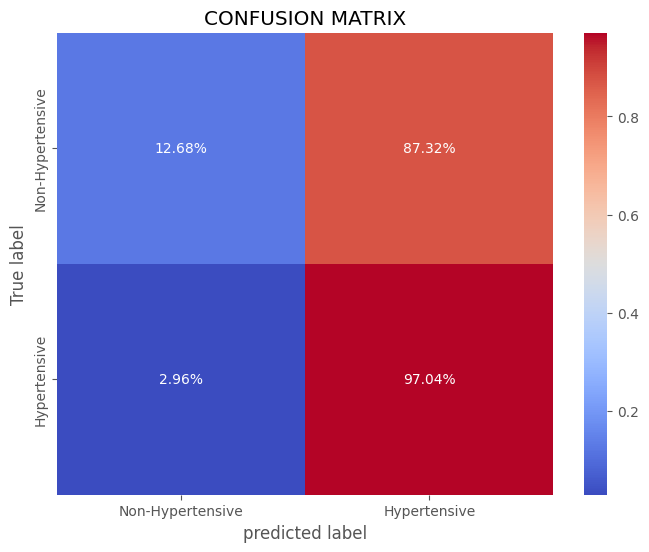

In [19]:
# initialize the logistic regression model
model = LogisticRegression(max_iter=10000, C = 0.1)


# fit and train the model
model.fit(X_train, y_train)

# evaluate the model predictions
y_pred = model.predict(X_test)

# evaluate the model accuracy
compute_metrics(y_test, model.predict(X_test), model.predict_proba(X_test)[:,1], 'log_reg')

plot_conf_matrix(y_test, y_pred)

### Random Forest
Next, we implement a Random Forest classifier, which can capture non-linear relationships in the data.


Accuracy: 0.8099
Recall: 0.9781
F1-score: 0.8933
AUC Score: 0.8815


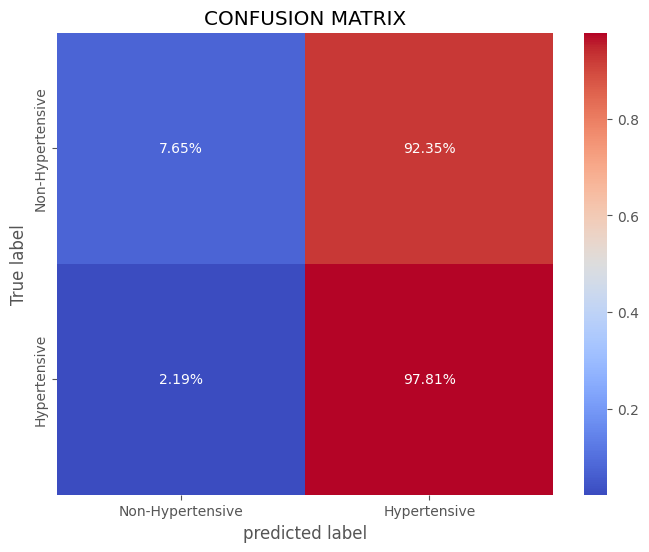

In [20]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 8)

# Fit and train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Get prediction probabilities
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
compute_metrics(y_test, y_pred_rf, y_pred_proba_rf, 'Random Forest')


plot_conf_matrix(y_test, y_pred_rf)

### XGBoost
We then use XGBoost, an efficient implementation of gradient boosting machines.


Accuracy: 0.8128
Recall: 0.9062
F1-score: 0.8873
AUC Score: 0.8835


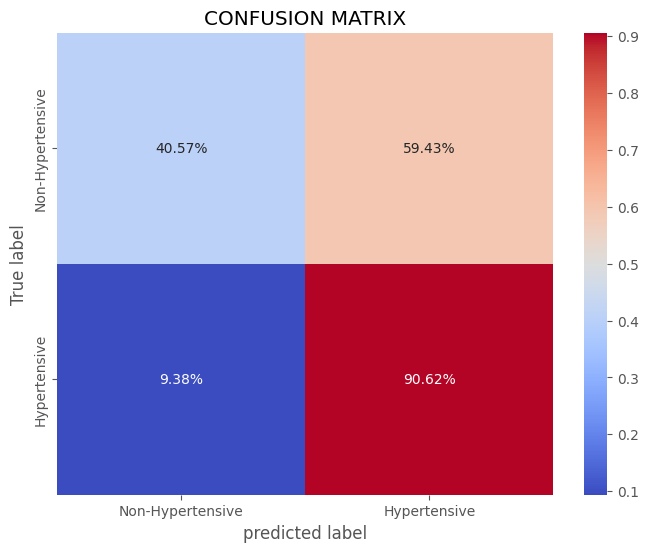

In [21]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb_model = XGBClassifier(n_estimators=3000, random_state=42, max_depth=6
                          , learning_rate=0.005, eval_metric='logloss')

# Fit and train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Get prediction probabilities
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
compute_metrics(y_test, y_pred_xgb, y_pred_proba_xgb, 'XGBoost')

# Plot confusion matrix
plot_conf_matrix(y_test, y_pred_xgb)

### Catboost

Finally, we implement CatBoost, which is particularly good at handling categorical features.



Accuracy: 0.8079
Recall: 0.9036
F1-score: 0.8844
AUC Score: 0.8809


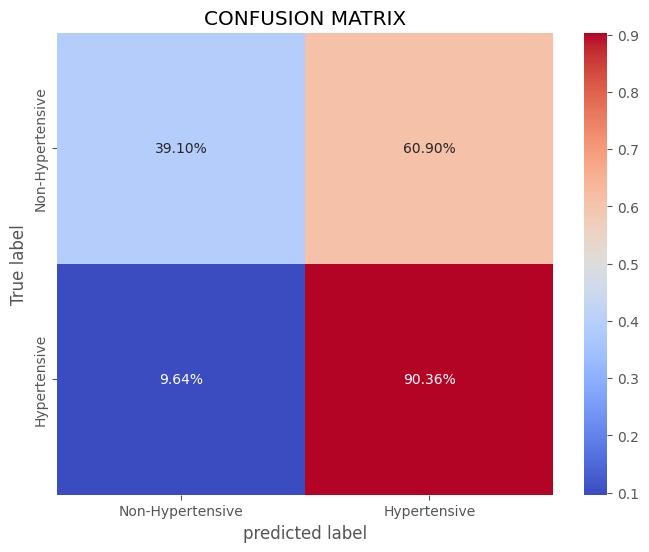

In [22]:
from catboost import CatBoostClassifier

# Initialize the CatBoost model
cat_model = CatBoostClassifier(n_estimators=3000,
                               random_seed=42,
                               max_depth=6,
                               learning_rate=0.005,
                               eval_metric='Logloss',
                               verbose=False)

# Fit and train the model
cat_model.fit(X_train, y_train)

# Make predictions
y_pred_cat = cat_model.predict(X_test)

# Get prediction probabilities
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluate the model
compute_metrics(y_test, y_pred_cat, y_pred_proba_cat, 'CatBoost')

# Plot confusion matrix
plot_conf_matrix(y_test, y_pred_cat)

## Hyperparameter Tuning with Optuna
To improve our models' performance, we use Optuna for hyperparameter optimization. This helps us find the best configuration for our CatBoost and XGBoost models.



### Install Optuna

In [23]:
! pip install optuna -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


### Define objectives and hyperparamters search space

In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold


def objective_catboost(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0),
        'max_bin': trial.suggest_int('max_bin', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'rsm': trial.suggest_float('rsm', 0.1, 1.0),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced','SqrtBalanced', 'None']),
        'random_seed': 42,
        'task_type': 'CPU',
        'verbose': False,
        'bootstrap_type': 'Bernoulli'
    }
    model = CatBoostClassifier(**params)

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform stratified 5-fold cross-validation
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

    # Return the mean cross-validation score
    return scores.mean()

def optimize_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1200),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'use_label_encoder': False,
        'seed': 42
    }
    xgb = XGBClassifier(**params)

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform stratified 5-fold cross-validation
    scores = cross_val_score(xgb, X, y, cv=skf, scoring='accuracy')

    # Return the mean cross-validation score
    return scores.mean()

### Run Catboost Trials

In [ ]:
%%time
cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(objective_catboost, n_trials=50)
print('Number of finished trials:', len(cat_study.trials))
print('Best trial:', cat_study.best_trial.params)
print('Best accuracy:', cat_study.best_value)

### Optimized Catboost

Accuracy: 0.8029
Recall: 0.8966
F1-score: 0.8809
AUC Score: 0.8804


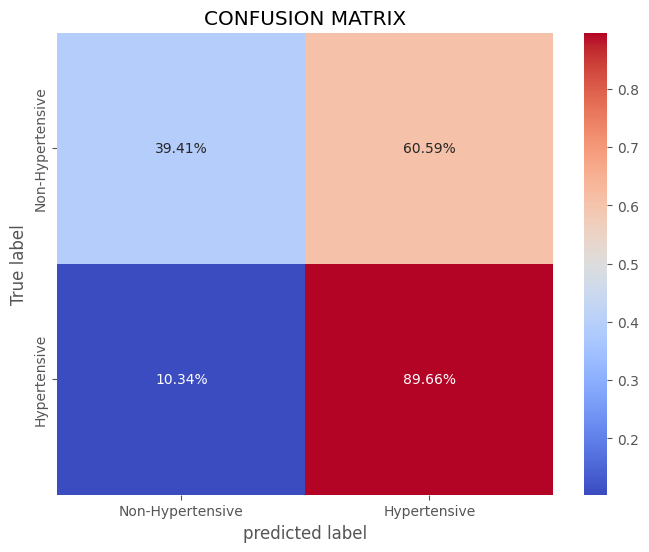

In [25]:
opt_cat_params = {'max_depth': 2, 'learning_rate': 0.05136077862271688, 'n_estimators': 1979, 'reg_lambda': 8.621907264739008, 'max_bin': 752, 'subsample': 0.26640564897919794, 'rsm': 0.745255197285868, 'auto_class_weights': 'None'}
opt_cat_params.update({'random_seed': 42, 'task_type': 'CPU', 'verbose': False, 'bootstrap_type': 'Bernoulli'})

opt_cat_model = CatBoostClassifier(**opt_cat_params)
opt_cat_model.fit(X_train, y_train)
y_pred_opt_cat = opt_cat_model.predict(X_test)
compute_metrics(y_test, y_pred_opt_cat, opt_cat_model.predict_proba(X_test)[:, 1], 'Optimized CatBoost')
plot_conf_matrix(y_test, y_pred_opt_cat)

### Xgboost Trials

In [ ]:
%%time
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(optimize_xgb, n_trials=50)
print('Number of finished trials:', len(xgb_study.trials))
print('Best trial:', xgb_study.best_trial.params)
print('Best accuracy:', xgb_study.best_value)

### Optimized Xgboost

Accuracy: 0.8091
Recall: 0.9548
F1-score: 0.8906
AUC Score: 0.8815


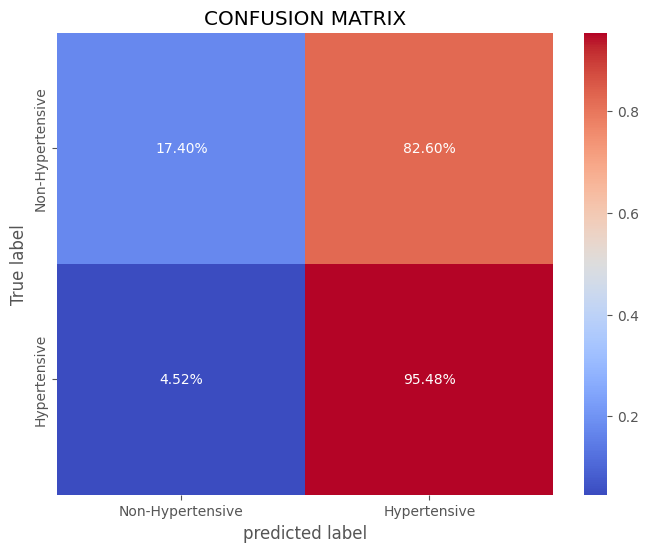

In [26]:
opt_xgb_params = {'learning_rate': 0.0948057059693159, 'max_depth': 10, 'n_estimators': 320, 'colsample_bytree': 0.7439268713391892, 'subsample': 0.5039555732494114, 'scale_pos_weight': 6.360351975149168, 'gamma': 0.448224571579524}
opt_xgb_params.update({'objective': 'binary:logistic', 'eval_metric': 'error',  'seed': 42})

opt_xgb_model = XGBClassifier(**opt_xgb_params)
opt_xgb_model.fit(X_train, y_train)
y_pred_opt_xgb = opt_xgb_model.predict(X_test)
compute_metrics(y_test, y_pred_opt_xgb, opt_xgb_model.predict_proba(X_test)[:, 1], 'Optimized XGBoost')
plot_conf_matrix(y_test, y_pred_opt_xgb)

## Ensemble Model with Cross-Validation

In this section, we implement an ensemble model using a Voting Classifier and evaluate its performance using Stratified K-Fold cross-validation. This approach combines the strengths of our best-performing models (CatBoost, XGBoost, and Logistic Regression) to create a more robust and accurate predictor. We use soft voting, which averages predicted probabilities, and assign higher weights to CatBoost and XGBoost.

Our cross-validation strategy employs a 5-fold Stratified K-Fold to ensure robust performance estimation, handle potential data imbalance, and assess the model's generalizability. For each fold, we train the ensemble on the training data, evaluate it on the validation set, and make predictions on the test set.

After completing cross-validation, we calculate the average ensemble accuracy across all folds to get a reliable estimate of our model's performance. Finally, we combine the test set predictions from all folds and round the results to obtain integer class labels. This comprehensive approach provides a thorough evaluation of our ensemble model and generates robust predictions for the test set.

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold


# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation results
ensemble_scores = []

# Initialize list to store test set predictions
test_predictions = []

# Voting classifier with soft voting and optional weights
voting_clf = VotingClassifier(estimators=[
    ('catboost', opt_cat_model),
    ('xgboost', opt_xgb_model),
    ('log_reg', model)],
    voting='soft',  # Use 'soft' for averaging predicted probabilities
    weights=[2, 2, 1]  # Assign weights to the models
)

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    print(f"Fold {fold}")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the ensemble model on the training set
    voting_clf.fit(X_train, y_train)

    # Predict validation set
    ensemble_preds_val = voting_clf.predict(X_val)
    ensemble_score = accuracy_score(y_val, ensemble_preds_val)
    ensemble_scores.append(ensemble_score)
    print(f"Ensemble Accuracy: {ensemble_score:.4f}")

    # Predict on test set
    ensemble_preds_test = voting_clf.predict(processed_test[main_feats])
    test_predictions.append(ensemble_preds_test)

    print()

# Print average scores across all folds
print("Average Ensemble Accuracy Across All Folds:")
print(f"Ensemble: {np.mean(ensemble_scores):.4f}")

# Combine test predictions from all folds (average predictions if needed)
final_predictions = np.mean(test_predictions, axis=0)

# Round the final predictions to get integer class labels
final_predictions_rounded = np.round(final_predictions).astype(int)

Fold 1
Ensemble Accuracy: 0.8118

Fold 2
Ensemble Accuracy: 0.8186

Fold 3
Ensemble Accuracy: 0.8042

Fold 4
Ensemble Accuracy: 0.8199

Fold 5
Ensemble Accuracy: 0.8151

Average Ensemble Accuracy Across All Folds:
Ensemble: 0.8139


## Submission

In [30]:
# Create submission dataframe
sample_sub ['target'] =  final_predictions_rounded.astype(int)

# Save to CSV
sample_sub.to_csv('/content/submission_voting_classifier.csv', index=False)

display(sample_sub)

,Id,target
0,16501,1
1,10444,1
2,14288,1
3,10409,1
4,17330,1
...,...,...
2692,14964,1
2693,16774,1
2694,18884,1
2695,10000,1
